$\newcommand{\E}{\mathbb{E}}$

# Some Inner Product Sketches.

I'll empirically compare some inner product sketches. I pick two vectors $x$ and $y$ in $\mathbb{R}^d$. Then each sketch produces random scalars $\hat{x}$ and $\hat{y}$ so that $\E \hat{x} \hat{y} = x^\top y$.

A sketch that does surprisingly well is asymmetric: It samples an index
according to the magnitude of $y$. It sketches $x$ using that randomly chosen
index, and sketches $y$ with just its sign.

## Gaussian sketch

Sketch $x$ and $y$ in the same way, as the dot product of a Gaussian random vector and each of $x$ and $y$:

$$\begin{align*}
 w &\sim \mathcal{N}(0, 1) \\ 
 \hat{x} &= w^\top x \\
 \hat{y} &= w^\top y
\end{align*}$$

To verify this is a sketch, 
$$\E \hat{x} \hat{y} = \E w^\top x w^\top y = x^\top \E w w^\top y = x^\top y.$$

The last equality follows because $\E w_i w_j = \delta(i, j)$.

# Random sign sketch

Sektch $x$ and $y$ in the same way, as the dot product of a random sign vector and each of $x$ and $y$:

$$\begin{align*}
 w &\sim \text{Rademacher}(0.5) \\ 
 \hat{x} &= w^\top x \\
 \hat{y} &= w^\top y
\end{align*}$$

To verify this is a sketch:
$$\E \hat{x} \hat{y} = \E w^\top x w^\top y = x^\top \E w w^\top y = x^\top y.$$

The last equality follows because $\E w_i w_j = \delta(i, j)$.

## Uniform sampling sketch

Sample an index $i$ uniformly at random from $\{1, \ldots, d\}$. Then sketch $x$ and $y$ as the dot product of the $i$th coordinate of $x$ and $y$:

$$\begin{align*}
 i &\sim \text{Uniform}(1, d) \\ 
 \hat{x} &= \sqrt{d} x_i \\
 \hat{y} &= \sqrt{d} y_i
\end{align*}$$

To verify this is a sketch,
$$\E \hat{x} \hat{y} = \sum_{i=1} \frac{1}{d} \sqrt{d} x_i \sqrt{d} y_i = \sum_i x_i y_i = x^\top y.$$


## Magnitude weight-sampling

Sample an index $i$ from $\{1, \ldots, d\}$ with probability proportional to $|y_i|$. From there, $x$ and $y$ undergo different sketches based on $i$:
$$\begin{align*}
i&\sim \frac{|y_i|}{\sum_j |y_j|} \\
\hat{x} &= x_i \\
\hat{y} &= \text{sign}(y_i) \sum_j |y_j| 
\end{align*}$$

To verify this is a sketch,
$$\begin{align*}
\E \hat{x} \hat{y} &= \left(\sum_{i=1} \frac{|y_i|}{\sum_j |y_j|}\right)  x_i \left(\text{sign}(y_i) \sum_j |y_j|\right) \\
&= \sum_{i=1} |y_i|  x_i \text{sign}(y_i) \\
&= \sum_{i=1} y_i  x_i \\
&= x^\top y.
\end{align*}$$

Computing the product $\hat{x} \hat{y}$ requires flipping the sign of $\hat{x}$, and multiplying it by a constant $\sum_j |y_j|$. The cost of this latter multiplication can
be amortized over repeated sketches, so it's negligible.  

Notice that the sketch for $x$ depends on the vector $y$ indirectly throug the
sampling distribution for $i$. That means we can't sketch $x$ until we've
observed $y$. Nevertheless, this sketch is practical in the sense that it offers
a quick estimate of $x^\top y$ with without paying the cost of a floating point
multiplication.

,Estimate,Std
True dot product,671.353931,0.000000
Sign y projections,671.459087,135.391227
Sign x projections,671.827463,288.795703
Uniform estimates,665.755689,519.994734
Gaussian projection,676.828527,960.408773
Random sign projection,675.414657,922.334680


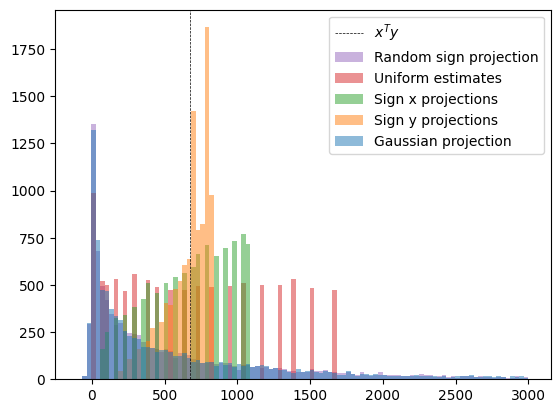

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

num_dims = 20
x = np.arange(num_dims) ** 0.5
y = np.arange(num_dims)

num_projections = 10000

# Estimate the dot product with Gaussian projections
w = np.random.randn(num_projections, num_dims)
xy_gaussian_estimates = (w @ x) * (w @ y)


# Estimate the dot product by uniformly sampling entries of the vectors.
i = np.random.choice(num_dims, size=num_projections, replace=True)
xy_uniform_estimates = x[i] * y[i] * num_dims


# Estimate the dot product by sampling entries using the magnitude of the
# entries of y.
def sign_project(x, y):
    y_abs = np.abs(y)
    i = np.random.choice(
        num_dims, size=num_projections, replace=True, p=y_abs / y_abs.sum()
    )
    return x[i] * np.sign(y[i]) * y_abs.sum()


xy_signy_estimates = sign_project(x, y)
xy_signx_estimates = sign_project(y, x)

# Estimate the dot product using random signs.
w = np.random.choice([-1, 1], size=(num_projections, num_dims))
xy_sign_estimates = (w @ x) * (w @ y)

plt.axvline(x @ y, color="black", ls="--", lw=0.5, label="$x^Ty$")
plt.hist(
    [
        xy_gaussian_estimates,
        xy_signy_estimates,
        xy_signx_estimates,
        xy_uniform_estimates,
        xy_sign_estimates,
    ],
    bins=np.linspace(-100, 3000, 100),
    histtype="stepfilled",
    label=(
        "Gaussian projection",
        "Sign y projections",
        "Sign x projections",
        "Uniform estimates",
        "Random sign projection",
    ),
    alpha=0.5,
)
plt.legend(loc="upper right")


def stats(estimates):
    return (estimates.mean(), estimates.std())


pd.DataFrame(
    {
        "True dot product": [x @ y, 0],
        "Sign y projections": stats(xy_signy_estimates),
        "Sign x projections": stats(xy_signx_estimates),
        "Uniform estimates": stats(xy_uniform_estimates),
        "Gaussian projection": stats(xy_gaussian_estimates),
        "Random sign projection": stats(xy_sign_estimates),
    },
    index=["Estimate", "Std"],
).T

# Observations

The spread of the magnitude sketches is much smaller thant the other sketches.
To get an accurate estimate of the inner product, we'll need to replicate the
sketch fewer times.